In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService

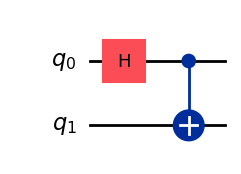

In [2]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")


In [3]:
# Set up six different observables.
# Each observable is a Pauli operator acting on one or two qubits.
# The labels are used to identify the observables in the results.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

Optimize the circuits and operators

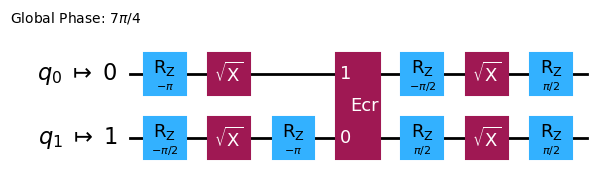

In [4]:
service = QiskitRuntimeService()

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

Execute using the quantum primitives

In [9]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: f0a86377-914f-44d3-ace2-f731e664b92e


/Users/mzitoh/anaconda3/envs/qiskit_env/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 5000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [10]:
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [11]:
pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>)), metadata={'target_precision': 0.015625})

In [12]:
 
# To run on a simulator:
 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]

Analyze the results

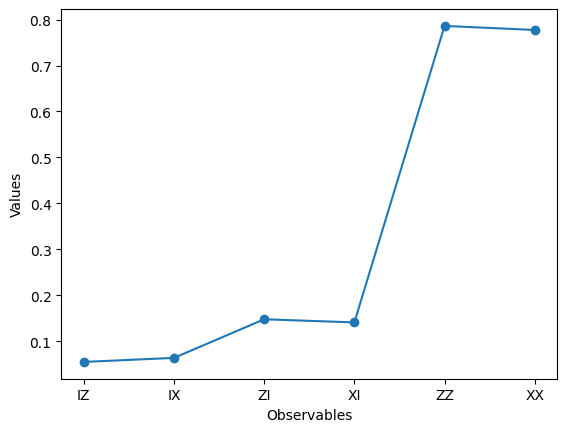

In [13]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (XX and ZZ) are 1. This is a hallmark of quantum entanglement.